# **Detecção de Fraudes em Cartões de Crédito - Modelo Machine Learning** 

O investimento na área de detecção de fraudes por meio da Inteligência 
Artificial vem crescendo conforme o passar dos anos, 
por isso resolvi desenvolver um projeto para analisar operações financeiras
afim de encontrar um bom modelo de classificação que identifique e possivelmente, evite transações fraudulentas.

Os dados utilizados nesse projeto estão disponíveis na plataforma do Kaggle e
podem ser encontrados [neste link](https://https://www.kaggle.com/mlg-ulb/creditcardfraud).

O dataset representa as operações financeiras que ocorreram no período de dois dias. Os dados anonimizados foram disponibilizados por empresas de cartão de crédito. 

Outra característica importante para se falar é que o dataset passou por uma transformação com o intuito de diminuir a dimensinalidade dos dados. A tranformação adotada é conhecida como PCA(Principal Component Analysis). 

Para saber mais sobre o PCA, [acesse esse link](https://en.wikipedia.org/wiki/Principal_component_analysis#:~:text=In%20machine%20learning%2C%20principal%20component,the%20variance%20of%20each%20dimension.).

<center><img src="https://media.giphy.com/media/NQ23lFzPwx6VuztnZN/source.gif" width="300"></center>

**Importando os e lendo os dados**

In [ ]:
# importando as bibliotecas necessárias
!pip install scikit-plot

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import scikitplot as skplt
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# configurando o estilo dos gráficos com seaborn
sns.set_style('dark')

In [ ]:
# importando e visualizando os dados
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"
df = pd.read_csv(file_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **Análise Exploratória dos Dados**  

In [ ]:
print('Dimensões do DataFrame:')
print(f'Linhas:  {df.shape[0]}')
print(f'Colunas:  {df.shape[1]}')

Dimensões do DataFrame:
Linhas:  284807
Colunas:  31


In [ ]:
# colunas do DataFrame
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# verificando a existência de valores NaN
df.isnull().values.any()

False

In [ ]:
# resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Não Fraudes: 284315
Fraudes: 492

Não Fraudes: 99.83%
Fraudes: 0.17% 


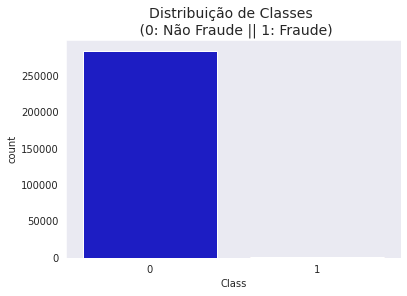

In [ ]:
# transações não fraudulentas e fraudulentas
print('Não Fraudes: {}'.format((df['Class'].value_counts()[0])))
print('Fraudes: {}'.format((df['Class'].value_counts()[1])))
# porcentagem 
print('\nNão Fraudes: {:.2f}%'.format((df[df.Class == 0].shape[0] / df.shape[0]) * 100))
print('Fraudes: {:.2f}% '.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

colors = ["#0101DF", "#DF0101"]
ax = sns.countplot(x='Class', data=df, palette=colors)
ax.set_title('Distribuição de Classes \n (0: Não Fraude || 1: Fraude)', fontsize=14);

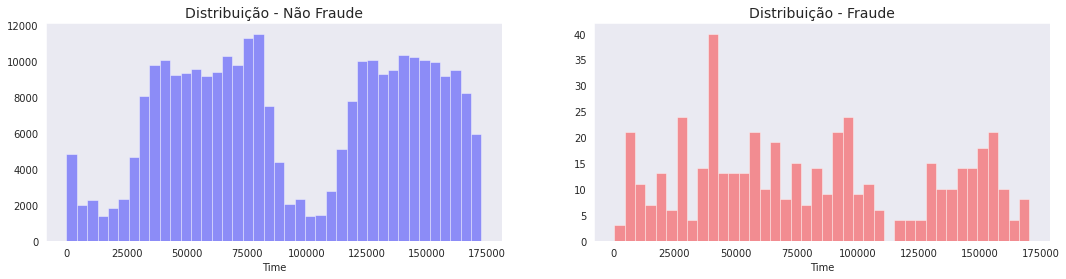

In [ ]:
# comparar as distribuições das 2 classes
fig, ax = plt.subplots(1, 2, figsize=(18,4))

class_0 = df.Time[df.Class == 0]
class_1 = df.Time[df.Class == 1]

sns.distplot(class_0, ax=ax[0], color='b', bins=40, kde=False)
ax[0].set_title('Distribuição - Não Fraude', fontsize=14)


sns.distplot(class_1, ax=ax[1], color='r', bins=40, kde=False)
ax[1].set_title('Distribuição - Fraude', fontsize=14);

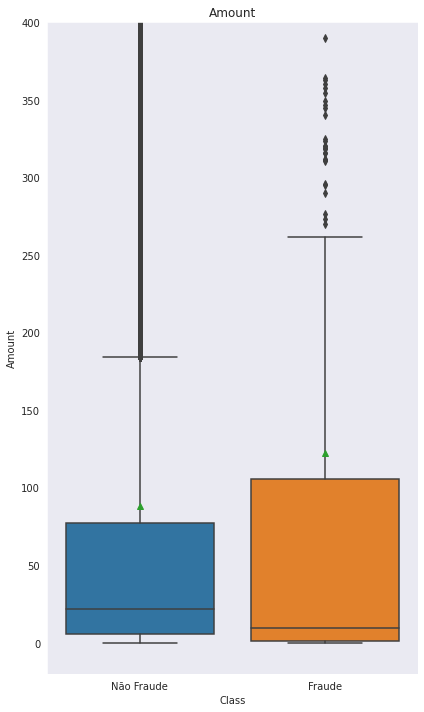

In [ ]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)
sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Não Fraude', 'Fraude'])
plt.title('Amount')

plt.tight_layout()

## **Preparando os Dados** 

Para colocar as nossas variáveis na mesma ordem de gradeza, precisamos

padronizar as variáveis *Amount* e *Time*.


In [ ]:
# RobustScaler é menos sensível a outliers
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
# divisão dos dados em treino e teste
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

**Balanceamento dos dados**  
Como vimos anteriormente, há uma presença maior de dados não fraudulentos, 

representando assim apenas 0.17% dos dados. 

Precisamos tratar esse desbalanceamento
para não inviesar o nosso algoritmo na hora do treinamento. 

A técnica que será utilizada para balancear os dados será usando a biblioteca imblearn. 
Usaremos a técnica Under-sampling. 

Para ler mais sobre essa técnica, [clique aqui](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html).


1    369
0    369
dtype: int64


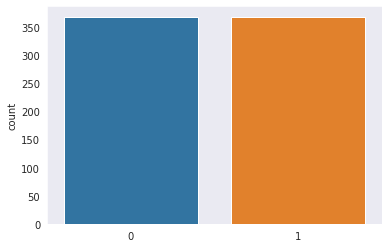

In [ ]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

print(pd.Series(y_rus).value_counts())

# visualizando a nova distribuição de classes
sns.countplot(y_rus);

Mais uma etapa importante durante a análise de dados é a visualizar a correlação entre as variáveis.  

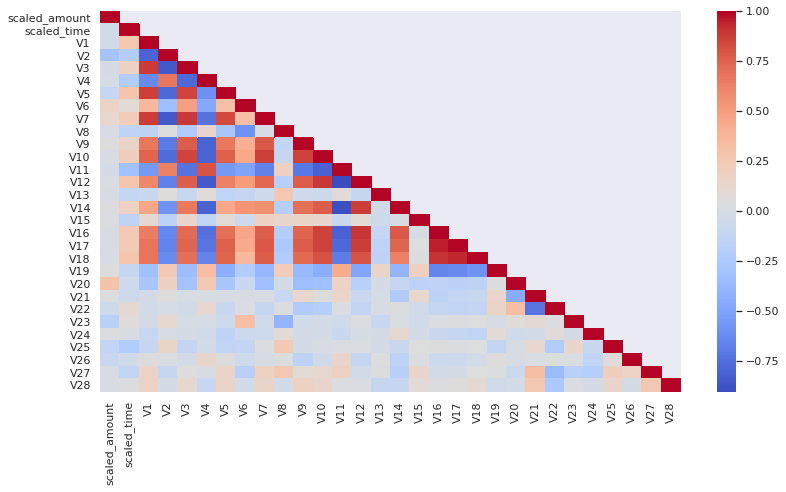

In [ ]:
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
mask = np.zeros_like(corr_rus)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns, 
                mask=mask, cmap='coolwarm')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

## **Criação do Modelo de Classificação**  

In [ ]:
# Regressão Logística
np.random.seed(2)

model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazendo as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

> **Métricas**  

Avaliando o modelo de Regressão Logística

In [ ]:
# imprimindo a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimindo a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Acurácia: 0.9534

AUC: 0.9523



In [ ]:
# imprimindo relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9534    0.9761     71079
           1     0.0341    0.9512    0.0659       123

    accuracy                         0.9534     71202
   macro avg     0.5170    0.9523    0.5210     71202
weighted avg     0.9982    0.9534    0.9745     71202



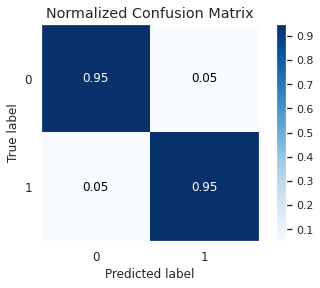

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# plotando a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True);